In [1]:
from typing import Any, Tuple, Dict
from transformers import CLIPTextModel, AutoTokenizer
import clip
import torch.nn.functional as F

import torchvision.transforms as transforms
from torch.utils.data import Dataset

from collections import defaultdict
from pycocotools.coco import COCO
from PIL import Image

import random
import numpy as np
import torch
import os

In [2]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [3]:
COCO_DIR = "/projects/rsalakhugroup/datasets/coco/coco_2017"

TRAIN_IMAGE_DIR = os.path.join(COCO_DIR, "train2017")
VAL_IMAGE_DIR = os.path.join(COCO_DIR, "val2017")

DEFAULT_TRAIN_INSTANCES = os.path.join(
    COCO_DIR, "annotations/instances_train2017.json")
DEFAULT_VAL_INSTANCES = os.path.join(
    COCO_DIR, "annotations/instances_val2017.json")

In [4]:
class COCODataset(Dataset):

    class_names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 
        'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 
        'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 
        'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 
        'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 
        'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 
        'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 
        'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 
        'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 
        'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 
        'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 
        'scissors', 'teddy bear', 'hair drier', 'toothbrush']

    num_classes: int = len(class_names)
        
    def get_specific_name(self, x, annotation):
        
        return self.cocoapi.cats[annotation["category_id"]]["name"]
    
    def verify_class_name(self, annotation):
        
        return self.cocoapi.cats[annotation[
            "category_id"
        ]]["name"] in self.class_names

    def __init__(self, split: str = "train", seed: int = 0, 
                 train_image_dir: str = TRAIN_IMAGE_DIR, 
                 val_image_dir: str = VAL_IMAGE_DIR, 
                 train_instances_file: str = DEFAULT_TRAIN_INSTANCES, 
                 val_instances_file: str = DEFAULT_VAL_INSTANCES, 
                 examples_per_class: int = None, 
                 image_size: Tuple[int] = (256, 256),
                 minimum_area: float = 2000.0):

        super(COCODataset, self).__init__()

        image_dir = {"train": train_image_dir, "val": val_image_dir}[split]
        instances_file = {"train": train_instances_file, "val": val_instances_file}[split]
        
        self.cocoapi = COCO(instances_file)
        self.examples_per_class = examples_per_class

        class_to_images = defaultdict(list)
        class_to_annotations = defaultdict(list)
        
        for image_id, x in self.cocoapi.imgs.items():
            
            annotations = list(filter(self.verify_class_name, 
                                      self.cocoapi.imgToAnns[image_id]))
            
            specific_names = [self.get_specific_name(
                x, annotation) for annotation in annotations]
            
            for sel_name in set(specific_names):
                
                specific_annotations = [ann for ann, ann_name in zip(
                    annotations, specific_names) if ann["area"] > 
                    minimum_area and sel_name == ann_name]
            
                if len(specific_annotations) == 0: continue
                image_path = os.path.join(image_dir, x["file_name"])
            
                class_to_images[sel_name].append(image_path)
                class_to_annotations[sel_name].append(specific_annotations)
                
        self.class_names = list(sorted(list(class_to_images.keys())))
        self.num_classes = len(self.class_names)
                
        rng = np.random.default_rng(seed)
        class_to_ids = {key: rng.permutation(
            len(class_to_images[key])) for key in self.class_names}

        if examples_per_class is not None:
            class_to_ids = {key: ids[:examples_per_class] 
                            for key, ids in class_to_ids.items()}

        self.class_to_images = {
            key: [class_to_images[key][i] for i in ids] 
            for key, ids in class_to_ids.items()}

        self.class_to_annotations = {
            key: [class_to_annotations[key][i] for i in ids] 
            for key, ids in class_to_ids.items()}

        self.all_images = sum([
            self.class_to_images[key] 
            for key in self.class_names], [])

        self.all_annotations = sum([
            self.class_to_annotations[key] 
            for key in self.class_names], [])

        self.all_labels = [i for i, key in enumerate(
            self.class_names) for _ in self.class_to_images[key]]

        self.transform = transforms.Compose([
            #transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float),
            transforms.Lambda(lambda x: x.expand(3, *x.shape[1:])),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                  std=[0.5, 0.5, 0.5])
        ])
        
        self.mask_transform = transforms.Compose([
            #transforms.Resize(image_size, interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ])

    def __len__(self):
        
        return len(self.all_images)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        
        image_path = self.all_images[idx]
        label = self.all_labels[idx]
        
        image = Image.open(image_path).convert('RGB')
        class_name = self.class_names[label]

        total_mask = None
        for annotation in self.all_annotations[idx]:
        
            mask = np.where(self.cocoapi.annToMask(
                annotation), 255, 0).astype(np.uint8)
            total_mask = (mask if total_mask is None 
                          else np.maximum(mask, total_mask))
            
        mask = self.mask_transform(Image.fromarray(total_mask))
        return self.transform(image), class_name, mask.to(torch.int64)
            

In [5]:
COCODataset.class_names = ["cat"]
dataset = COCODataset(examples_per_class=8)

loading annotations into memory...
Done (t=13.39s)
creating index...
index created!


In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
    
def get_new_pallete(num_cls):
    n = num_cls
    pallete = [0]*(n*3)
    for j in range(0,n):
            lab = j
            pallete[j*3+0] = 0
            pallete[j*3+1] = 0
            pallete[j*3+2] = 0
            i = 0
            while (lab > 0):
                    pallete[j*3+0] |= (((lab >> 0) & 1) << (7-i))
                    pallete[j*3+1] |= (((lab >> 1) & 1) << (7-i))
                    pallete[j*3+2] |= (((lab >> 2) & 1) << (7-i))
                    i = i + 1
                    lab >>= 3
    return pallete

def get_new_mask_pallete(npimg, new_palette, out_label_flag=False, labels=None):
    """Get image color pallete for visualizing masks"""
    # put colormap
    out_img = Image.fromarray(npimg.squeeze().astype('uint8'))
    out_img.putpalette(new_palette)

    if out_label_flag:
        assert labels is not None
        u_index = np.unique(npimg)
        patches = []
        for i, index in enumerate(u_index):
            label = labels[index]
            cur_color = [new_palette[index * 3] / 255.0, new_palette[index * 3 + 1] / 255.0, new_palette[index * 3 + 2] / 255.0]
            red_patch = mpatches.Patch(color=cur_color, label=label)
            patches.append(red_patch)
    return out_img, patches
    
new_palette = get_new_pallete(2)

In [7]:
from fine_tune import main, parse_args

for class_name, images in dataset.class_to_images.items():
    
    os.makedirs(os.path.join("images", class_name), exist_ok=True)
    file_names = []

    for i, image in enumerate(images):
        
        image_path = os.path.join(
            "images", class_name, f"image{i}.png")
        
        file_names.append(image_path)
        Image.open(image).save(image_path)
        
    concept_token = f"<{class_name.replace(' ', '_')}>"
        
    args = parse_args(args=[
        "--pretrained_model_name_or_path", "CompVis/stable-diffusion-v1-4",
        "--output_dir", os.path.join('fine-tuned', class_name),
        "--train_data_dir", os.path.join('images', class_name),
        "--placeholder_token", concept_token,
        "--initializer_token", "the",
        "--resolution", "512",
        "--train_batch_size", "4",
        "--lr_warmup_steps", "0",
        "--gradient_accumulation_steps", "1",
        "--max_train_steps", "1000",
        "--learning_rate", "5.0e-04",
        "--scale_lr",
        "--lr_scheduler", "constant",
        "--mixed_precision", "fp16",
        "--revision", "fp16",
        "--gradient_checkpointing",
        "--only_save_embeds",
    ])
    
    main(args=args)
    
    for image_path in file_names: 
        os.remove(image_path)

/home/btrabucc/anaconda3/envs/lang-seg/lib/python3.8/site-packages/accelerate/accelerator.py:243: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
03/21/2023 03:20:36 - INFO - fine_tune - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'clip_sample_range', 'variance_type', 'prediction_type'} was not found in config. Values will be initialized to default values.
{'norm_num_groups', 'scaling_factor'} was not found in config. Values will be initialized to default values.
{'conv_in_kernel', 'num_class_embeds', 'mid_block_type', 'time_embedding_type', 'projection_class_embeddings_input_dim', 'class_embed_type', 'use_linear_projection', 'conv_out_kernel', 'dual_cross_attention', 'upcast_attention', 'time_cond_proj_dim', 'timestep_post_act', 'resnet_time_scale_shift', 'only_cross_attention'} was not found in config. Values

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/btrabucc/anaconda3/envs/lang-seg/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
03/21/2023 03:27:46 - INFO - fine_tune - Saving embeddings
03/21/2023 03:34:51 - INFO - fine_tune - Saving embeddings
03/21/2023 03:34:51 - INFO - fine_tune - Saving embeddings


In [8]:
from modules.lseg_module import LSegModule
from encoding.models.sseg import BaseNet
from additional_utils.models import LSeg_MultiEvalModule

model = LSegModule.load_from_checkpoint(
    checkpoint_path='checkpoints/demo_e200.ckpt',
    data_path='../datasets/',
    dataset='ade20k',
    backbone='clip_vitl16_384',
    aux=False,
    num_features=256,
    aux_weight=0,
    se_loss=False,
    se_weight=0,
    base_lr=0,
    batch_size=1,
    max_epochs=0,
    ignore_index=255,
    dropout=0.0,
    scale_inv=False,
    augment=False,
    no_batchnorm=False,
    widehead=True,
    widehead_hr=False,
    map_locatin="cpu",
    arch_option=0,
    block_depth=0,
    activation='lrelu',
)
    
model = model.eval()
model = model.cpu()

scales = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]

model.mean = [0.5, 0.5, 0.5]
model.std = [0.5, 0.5, 0.5]

evaluator = LSeg_MultiEvalModule(
    model, scales=scales, flip=True
).cuda()
evaluator.eval()

** Use norm [0.5, 0.5, 0.5], [0.5, 0.5, 0.5] as the mean and std **
{'base_size': 520, 'crop_size': 480}
train
BaseDataset: base_size 520, crop_size 480
len(img_paths): 20210
val


/home/btrabucc/anaconda3/envs/lang-seg/lib/python3.8/site-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `Accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.classification.accuracy.Accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


MultiEvalModule: base_size 520, crop_size 480


LSeg_MultiEvalModule(
  (module): LSegModule(
    (train_accuracy): Accuracy()
    (val_accuracy): Accuracy()
    (net): LSegNet(
      (clip_pretrained): CLIP(
        (visual): VisionTransformer(
          (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
          (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (transformer): Transformer(
            (resblocks): Sequential(
              (0): ResidualAttentionBlock(
                (attn): MultiheadAttention(
                  (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
                )
                (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
                (mlp): Sequential(
                  (c_fc): Linear(in_features=768, out_features=3072, bias=True)
                  (gelu): QuickGELU()
                  (c_proj): Linear(in_features=3072, out_features=768, bias=True)
                )
                (ln_2): 

In [9]:
class_name = "cat"

In [10]:
import regex as re
from clip.clip import _tokenizer

ORIGINAL_VOCAB_SIZE = len(_tokenizer.encoder)

In [13]:
concept_tokens = [f"<{class_name.replace(' ', '_')}>" 
                  for class_name in dataset.class_names]

_tokenizer.pat = re.compile("|".join(concept_tokens + [
    r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+"""
]), re.IGNORECASE)

X = torch.load("L14-to-B32-linear.pt")

for i, class_name in enumerate(dataset.class_names):
    
    concept_token = f"<{class_name.replace(' ', '_')}>" 
    
    fine_tuned_embeds = torch.load(f"fine-tuned/{class_name}/learned_embeds.bin")

    for key, value in fine_tuned_embeds.items():
        fine_tuned_embeds[key] = value @ X

    _tokenizer.encoder[concept_token] = ORIGINAL_VOCAB_SIZE + i
    _tokenizer.decoder[_tokenizer.encoder[concept_token]] = concept_token

    _tokenizer.cache[concept_token] = concept_token

    embeds = evaluator.module.net.clip_pretrained.token_embedding
    embeds_weight = embeds.weight.data

    embeds_weight = F.pad(embeds_weight, (0, 0, 0, max(
        0, _tokenizer.encoder[concept_token] - 
        embeds_weight.shape[0] + 1)))
    
    embeds_weight[_tokenizer.encoder[concept_token]] = fine_tuned_embeds[concept_token]

    new_token_embedding = torch.nn.Embedding.from_pretrained(
        embeds_weight, freeze=True, padding_idx=embeds.padding_idx,
        max_norm=embeds.max_norm, norm_type=embeds.norm_type, 
        scale_grad_by_freq=embeds.scale_grad_by_freq, sparse=False)

    def encode_text(self, text):

        x = new_token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        eos_indices = (text == _tokenizer.encoder["<|endoftext|>"]).float().argmax(dim=-1)
        x = x[torch.arange(x.shape[0]), eos_indices] @ self.text_projection

        return x

    import types

    evaluator.module.net.clip_pretrained.encode_text = \
        types.MethodType(encode_text, evaluator.module.net.clip_pretrained)

** MultiEvalModule parallel_forward phase: ['other', '<cat>'] **
** MultiEvalModule forward phase: ['other', '<cat>'] **
For cat Accuracy: 0.9690024852752686 IoU: 0.8944476246833801


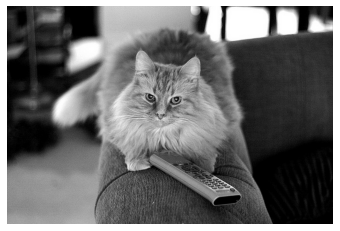

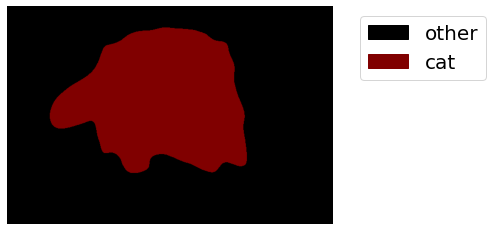

** MultiEvalModule parallel_forward phase: ['other', '<cat>'] **
** MultiEvalModule forward phase: ['other', '<cat>'] **
For cat Accuracy: 0.9951855540275574 IoU: 0.8970127701759338


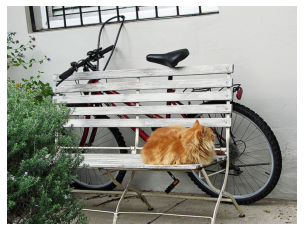

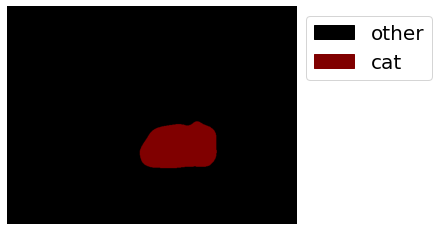

** MultiEvalModule parallel_forward phase: ['other', '<cat>'] **
** MultiEvalModule forward phase: ['other', '<cat>'] **
For cat Accuracy: 0.9912335276603699 IoU: 0.7146198749542236


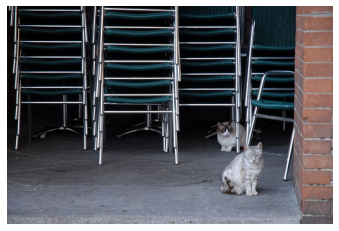

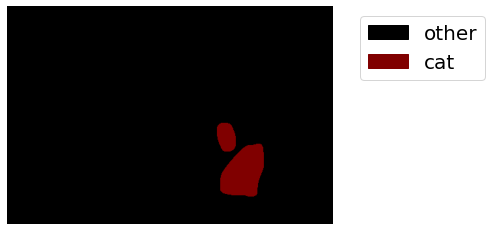

** MultiEvalModule parallel_forward phase: ['other', '<cat>'] **
** MultiEvalModule forward phase: ['other', '<cat>'] **
For cat Accuracy: 0.9645735621452332 IoU: 0.741772472858429


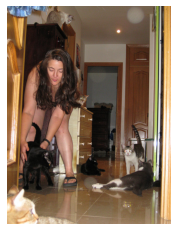

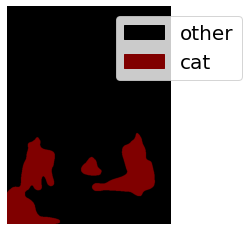

** MultiEvalModule parallel_forward phase: ['other', '<cat>'] **
** MultiEvalModule forward phase: ['other', '<cat>'] **
For cat Accuracy: 0.9705380201339722 IoU: 0.8890284299850464


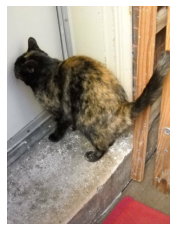

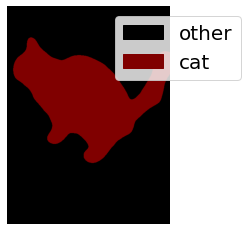

** MultiEvalModule parallel_forward phase: ['other', '<cat>'] **
** MultiEvalModule forward phase: ['other', '<cat>'] **
For cat Accuracy: 0.9573792815208435 IoU: 0.9092069864273071


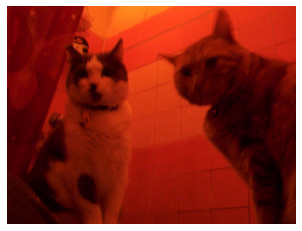

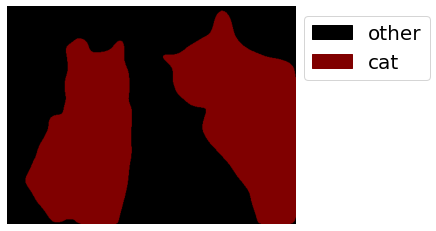

** MultiEvalModule parallel_forward phase: ['other', '<cat>'] **
** MultiEvalModule forward phase: ['other', '<cat>'] **
For cat Accuracy: 0.6201985478401184 IoU: 0.3850439190864563


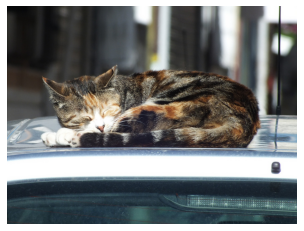

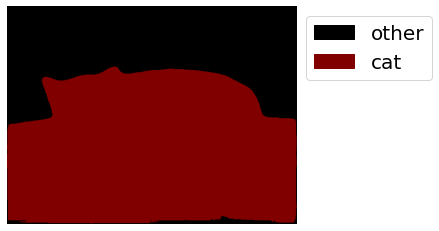

** MultiEvalModule parallel_forward phase: ['other', '<cat>'] **
** MultiEvalModule forward phase: ['other', '<cat>'] **
For cat Accuracy: 0.9712566137313843 IoU: 0.906186580657959


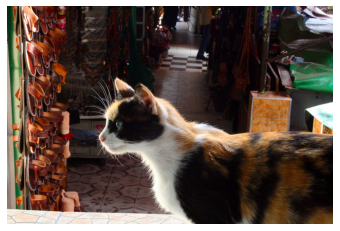

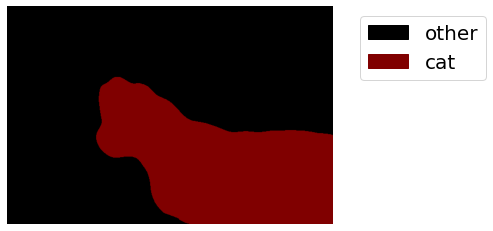

In [14]:
for image, class_name, mask in dataset:

    with torch.no_grad():

        output = evaluator.parallel_forward(
            image.unsqueeze(0), [
                "other", f"<{class_name.replace(' ', '_')}>"
            ])[0]
        
    predict = torch.max(output, 1)[1].cpu()
    
    pixel_accuracy = predict == mask
    pixel_accuracy = pixel_accuracy.float().mean().numpy().item()
    
    intersection = predict * mask
    union = predict + mask - intersection
    
    iou = (intersection.sum() / union.sum()).numpy().item()
    
    print("For", class_name, "Accuracy:", pixel_accuracy, "IoU:", iou)

    mask, patches = get_new_mask_pallete(
        predict.numpy(), new_palette, 
        out_label_flag=True, 
        labels=["other", class_name])

    img = image.permute(1,2,0)
    img = img * 0.5 + 0.5
    img = Image.fromarray(np.uint8(255*img)).convert("RGBA")
    seg = mask.convert("RGBA")

    out = Image.blend(img, seg, 0.5)

    plt.axis('off')
    plt.imshow(img)
    plt.figure()
    plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
    plt.axis('off')
    plt.imshow(seg)
    plt.show()